## Analytical Engineering Test

### Get embeddings by subdirectory and granularity level

In [1]:
import glob
import re

In [53]:
# Detect embedding type
filename = 'c.Class1_c.Class2_m.Method1_token(0).json'
filename = filename[:-5]
nesting = []
for m in re.finditer(r'(^|_)(c.|m.|token)', filename):
    # match m.group():
    #     case 'c.' | '_c.': level = 'class'
    #     case 'm.' | '_m.': level = 'method'
    #     case 'token' | '_token': level = 'token'
    #     case _:
    #         print("Something has gone wrong!")
    #         level = ''
    if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
    elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
    elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
    else:
        print("Something has gone wrong!")
        level = ''

    nesting.append((m.start(), m.end(), level))
nesting

[(0, 2, 'class'), (8, 11, 'class'), (17, 20, 'method'), (27, 33, 'token')]

In [ ]:
for i in range(1, len(nesting)):
    cur = nesting[i]
    prev = nesting[i-1]

    # Get identifier name and/or duplicate number
    print(filename[prev[1] : cur[0]])

# Print the last level
if cur[2] == 'token':
    print('token' + filename[cur[1]:])
else:
    print(filename[cur[1]:])

Class1
Class2
Method1
token(0)


In [ ]:
def parse_json_filename(filename:str) -> tuple[str, list[tuple[str]]]:
    '''
    Parse JSON filesnames produced by CodeEmbeddingsGenerator.py
    into the classes, methods, and tokens they are located in.

    Args:
        filename: JSON filename to parse.
    
    Returns:
        level: Coding level of granularity (i.e., "class", "method", "token")
        identifiers: An ordered list of the nested classes, methods, and/or token.
    '''
    f = filename[:-5]
    nesting = []
    for m in re.finditer(r'(^|_)(c\.|m\.|token)', f):
        if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
        elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
        elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
        else:
            print("Something has gone wrong!")
            level = ''

        nesting.append((m.start(), m.end(), level))

    identifiers = []
    for i in range(1, len(nesting)):
        end = nesting[i]
        start = nesting[i-1]

        # Get identifier name and duplicate number 
        # (or just duplicate number if its a token)
        name = f[start[1] : end[0]]
        identifiers.append((name, start[2])) # Store name and level

    # Get last name and level
    last = nesting[-1]
    name = f[last[1]:] 
    identifiers.append((name, last[2]))

    # Return embedding level and parsing results
    return last[2], identifiers

In [28]:
# Test
print(parse_json_filename('c.ClassA.json'))
print(parse_json_filename('c.ClassA_c.ClassB.json'))
print(parse_json_filename('c.ClassA_m.MethodA_m.MethodB.json'))
print(parse_json_filename('c.ClassA_token.json'))
print(parse_json_filename('c.ClassA_token(0).json'))

('class', [('ClassA', 'class')])
('class', [('ClassA', 'class'), ('ClassB', 'class')])
('method', [('ClassA', 'class'), ('MethodA', 'method'), ('MethodB', 'method')])
('token', [('ClassA', 'class'), ('', 'token')])
('token', [('ClassA', 'class'), ('(0)', 'token')])


In [3]:
def get_embedding_paths(sub_dirs:list[str] = ['data'], 
                        levels:list[str] = ['class', 'method', 'token'],
                        id_nestings:list[tuple[str]] = []
                        ) -> tuple[list[str], list[str]]:
    '''
    Return file paths for JSON files created by CodeEmbeddingsGenerator.py.
    Collects all JSON files in a data folder by default.

    sub_dirs: Paths to subdirectories within the data folder to collect the JSON files from.
    levels: Embedding levels to collect (i.e., "class", "method", "token").
    id_nestings: Ordered lists of classes and/or methods that the code fragments associated with 
        the embeddings must be found in. The format must match that of the the 2nd output of 
        parse_json_filename().

    Returns:
        embed_paths: Paths to the JSON files.
        embed_levels: Embedding levels associated with each path in embed_paths.
    '''
    for level in levels:
        if level not in ('class', 'method', 'token'):
            print(f'Warning: Invalid level name "{level}".')
            
    embed_paths = []
    embed_levels = []
    for dir in sub_dirs:
        # Search through all JSON files
        for path in glob.glob(dir + '/**/*.json', recursive=True):
            filename = re.split(r'\\|/', path)[-1] # Get filename (and file extension)
            level, identifiers = parse_json_filename(filename) # Get embedding level and the nesting
            # Collect paths to embeddings of specified levels
            if level in levels:
                if len(id_nestings) == 0:
                    embed_paths.append(path)
                    embed_levels.append(level)
                    continue
                # Collect paths to embeddings that are nested in the specified classes and/or methods
                for nesting in id_nestings:
                    if nesting == identifiers[:len(nesting)]:
                        embed_paths.append(path)
                        embed_levels.append(level)
                        break
    return embed_paths, embed_levels

In [ ]:
# Classes and methods in Ivy.java and Main.java
paths, levels = get_embedding_paths(sub_dirs = ['data/ivy/Ivy', 'data/ivy/Main'], levels = ['class', 'method'])
paths

['data/ivy/Ivy\\c.Ivy.json',
 'data/ivy/Ivy\\c.Ivy_m.assertBound.json',
 'data/ivy/Ivy\\c.Ivy_m.bind.json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress.json',
 'data/ivy/Ivy\\c.Ivy_m.check.json',
 'data/ivy/Ivy\\c.Ivy_m.checkInterrupted.json',
 'data/ivy/Ivy\\c.Ivy_m.configure(0).json',
 'data/ivy/Ivy\\c.Ivy_m.configure.json',
 'data/ivy/Ivy\\c.Ivy_m.configureDefault.json',
 'data/ivy/Ivy\\c.Ivy_m.configureDefault14.json',
 'data/ivy/Ivy\\c.Ivy_m.deliver(0).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver(1).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver.json',
 'data/ivy/Ivy\\c.Ivy_m.doInIvyContext.json',
 'data/ivy/Ivy\\c.Ivy_m.execute.json',
 'data/ivy/Ivy\\c.Ivy_m.findModule.json',
 'data/ivy/Ivy\\c.Ivy_m.getCheckEngine.json',
 'data/ivy/Ivy\\c.Ivy_m.getDeliverEngine.json',
 'data/ivy/Ivy\\c.Ivy_m.getEventManager.json',
 'data/ivy/Ivy\\c.Ivy_m.getInstallEngine.json',
 'data/ivy/Ivy\\c.Ivy_m.getIvyDate.json',
 'data/ivy/Ivy\\c.Ivy_m.getIvyHomeURL.json',
 'data/ivy/Ivy\\c.Ivy_m.getIvyVersion.json'

In [ ]:
# Methods and tokens in the bind method in the Ivy class from Ivy.java
paths, levels = get_embedding_paths(sub_dirs = ['data/ivy/Ivy'], 
                                    levels = ['method', 'token'],
                                    id_nestings = [[('Ivy','class'), ('bind','method')]]
                                    )
paths[:200]

['data/ivy/Ivy\\c.Ivy_m.bind.json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress.json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(0).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(1).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(10).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(100).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(101).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(102).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(103).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(104).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(105).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(106).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(107).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(108).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(109).json',
 'data/ivy/Ivy\\c.Ivy_m.bind_m.transferProgress_token(11

In [152]:
# Get deliver() methods and their tokens
# Note that the tokens are not differentiated specifically by which deliver method they're from
paths, levels = get_embedding_paths(sub_dirs = ['data/ivy/Ivy'], 
                                    levels = ['method', 'token'],
                                    id_nestings = [
                                        [('Ivy','class'), ('deliver','method')],
                                        [('Ivy','class'), ('deliver(0)','method')],
                                        [('Ivy','class'), ('deliver(1)','method')]
                                    ]
                                    )
paths

['data/ivy/Ivy\\c.Ivy_m.deliver(0).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver(1).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver.json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(0).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(1).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(10).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(100).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(101).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(102).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(103).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(104).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(105).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(106).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(107).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(108).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(109).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(11).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(110).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(111).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_token(112).json',
 'data/ivy/Ivy\\c.Ivy_m.deliver_t

---

### Brief analysis

In [6]:
from _collections_abc import Iterable
import json

import gudhi
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def paths_to_data(paths:Iterable[str]) -> dict:
    '''
    Takes a list of directory paths to JSON files generated by CodeEmbeddingsGenerator.py, 
    then loads the data and compiles them into a single dictionary.

    Args:
        paths: The list of directory paths to JSON files.

    Returns:
        data: A dataset of embeddings, the associated identifier/token name, 
            the start and end indices for parsing the original code fragment,
            and the directory path to the JSON file.
    '''
    data = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
    for path in paths:
        file = json.load(open(path, 'r'))
        data['embeds'].append(file[0][0]) # Embedding
        data['names'].append(file[1]) # Identifier or token name
        data['spans'].append(file[2]) # Start and end indices in source code
        data['paths'].append(path) # Path to file
    return data

In [30]:
paths, levels = get_embedding_paths(sub_dirs = ['data/ivy/Ivy'], levels = ['method']) # All methods from Ivy.java

In [ ]:
data = paths_to_data(paths)
data['levels'] = levels # Add embedding levels

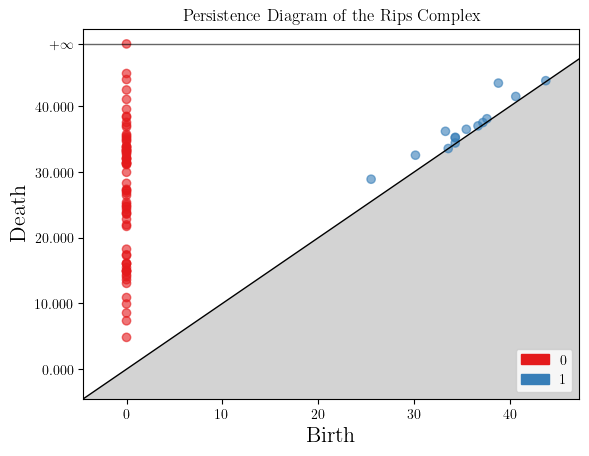

In [10]:
rips = gudhi.RipsComplex(points=data['embeds']) # Vietoris-Rips complex
tree = rips.create_simplex_tree(max_dimension=2)

# Plot persistence diagram
barcode = tree.persistence()
gudhi.plot_persistence_diagram(barcode)
plt.title('Persistence Diagram of the Rips Complex')
plt.show()

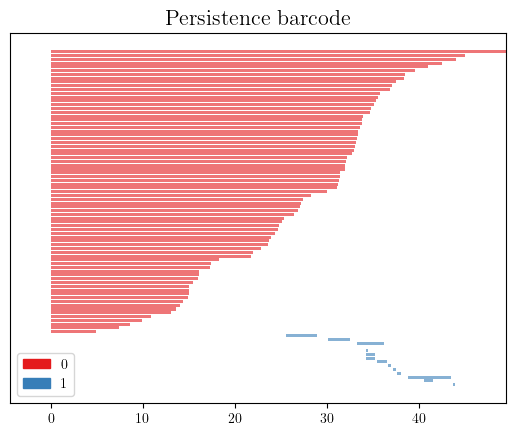

In [11]:
# Plot barcode
gudhi.plot_persistence_barcode(barcode)
plt.show()

In [12]:
def GetBettiCurvesFromPointCloud(X, J, dim=3):
    '''
    Computes the Betti curves of the Rips complex on the point cloud X, 
    on the interval J, up to dimension dim.

    Input:
        X (np.array): size Nx2, the point cloud.
        J (np.array): interval. Shape 1xM. 
        dim (int, optional): maximal dimension to compute the Betti curves. 
    
    Output:
        BettiCurves (np.array): the Betti curves. Shape (dim+1)xM. The ith 
                                Betti curve is given by BettiCurve[i,:].  
                                
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        J = np.linspace(0,1,100)
        GetBettiCurvesFromPointCloud(X, J, dim = 2)
    '''
    I = 2*J
    tmax = max(I)
    rips = gudhi.RipsComplex(points=X, max_edge_length = tmax)
    st = rips.create_simplex_tree(max_dimension=dim)
    st.persistence(persistence_dim_max=True, homology_coeff_field = 2)
    Diagrams = [st.persistence_intervals_in_dimension(i) for i in range(dim+1)]
    BettiCurves = []
    step_x = I[1]-I[0]
    for diagram in Diagrams:
        bc =  np.zeros(len(I))
        if diagram.size != 0:
            diagram_int = np.clip(np.ceil((diagram[:,:2] - I[0]) / step_x), 0, len(I)).astype(int)
            for interval in diagram_int:
                bc[interval[0]:interval[1]] += 1
        BettiCurves.append(np.reshape(bc,[1,-1]))
    return np.reshape(BettiCurves, (dim+1, len(I)))

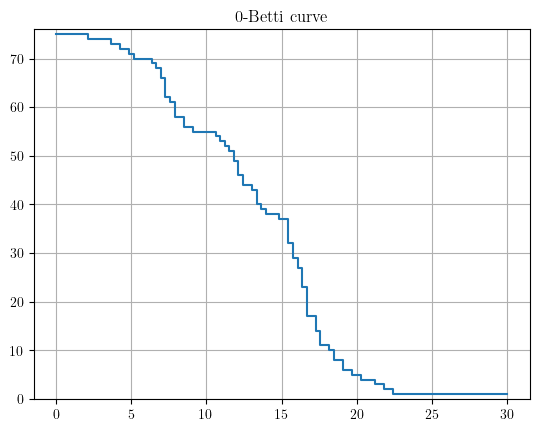

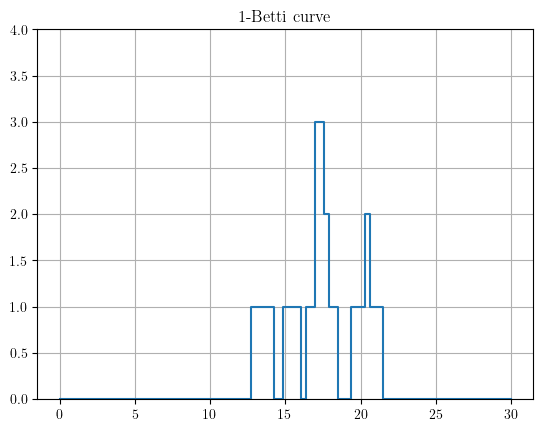

In [15]:
J = np.linspace(0,30,100)
dim = 2
betti_curves = GetBettiCurvesFromPointCloud(data['embeds'], J, dim=dim)

for d in range(dim):
    plt.figure()
    plt.step(J, betti_curves[d])
    plt.ylim(0, max(betti_curves[d])+1)
    plt.grid()
    plt.title(f'{d}-Betti curve')
    plt.show()

---

### Interactive 3D scatterplot using MDS and Plotly

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import plotly.graph_objects as go
# import plotly.express as px

In [ ]:
# Show in R^3
dists = pairwise_distances(data['embeds'])
mds = MDS(n_components=3, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1) # Multidimensional scaling
pos = mds.fit(dists).embedding_

# There's no intended meaning here. I just wanted to group the embeddings in some way.
color = [1 if sum(embed)>27 else 0 for embed in data['embeds']]
# Additional data to include in tooltips
customdata = np.stack((data['names'], [str(tuple(span)) for span in data['spans']]), axis=1)

fig = go.Figure(data=[go.Scatter3d(x=pos[:,0], y=pos[:,1], z=pos[:,2],
                                   mode='markers',
                                   marker=dict(color=color, colorscale='Bluered',
                                               size=5, opacity=0.7),
                                   customdata = customdata,
                                   hovertemplate = 'x: %{x} <br>y: %{y} <br>Method name: %{customdata[0]} <br>span: %{customdata[1]}',
                                   name = '' # Remove trace from tooltips
                                   )])

# Tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# fig.write_html('fig1.html')
fig.show() # Notebook viewers cannot show interactive plot; see htmls in the "figs" folder

In [ ]:
# Same as before, except color is based on start indices of the associated code fragments
color = [span[0] for span in data['spans']]

fig = go.Figure(data=[go.Scatter3d(x=pos[:,0], y=pos[:,1], z=pos[:,2],
                                   mode='markers',
                                   marker=dict(color=color, colorscale='Viridis',
                                               size=5, opacity=0.7),
                                   customdata = customdata,
                                   hovertemplate = 'x: %{x} <br>y: %{y} <br>Method name: %{customdata[0]} <br>span: %{customdata[1]}',
                                   name = '' # Remove trace from tooltips
                                   )])

# Tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# fig.write_html('fig2.html')
fig.show()